# MS05: The Digestive Neural System - Our Second Brain
## 500 Million Neurons in the Gut Think, Feel, and Remember
### Dr. Mordin Solus - Discovering the Enteric Intelligence

In [11]:
# Core imports
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyBboxPatch
import ipywidgets as widgets
from ipywidgets import interact
import h5py
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 4090
Memory: 25.3 GB


## 1. The Enteric Nervous System - A Complete Neural Network

The gut contains more neurons than the spinal cord - it can think, learn, and remember independently!

In [12]:
class DigestiveNeuralField:
    """Models the enteric nervous system and gut-brain axis."""
    
    def __init__(self, size=256, device='cuda'):
        self.size = size
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Neural field representing gut neurons
        self.neural_field = torch.zeros(1, 1, size, size, dtype=torch.complex64, device=self.device)
        
        # Gut segments with neural densities and functions
        self.gut_segments = {
            'esophagus': {'start': 0.9, 'end': 0.7, 'neurons': 0.1, 'function': 'swallowing'},
            'stomach': {'start': 0.7, 'end': 0.4, 'neurons': 0.3, 'function': 'churning'},
            'duodenum': {'start': 0.4, 'end': 0.3, 'neurons': 0.8, 'function': 'sensing'},
            'jejunum': {'start': 0.3, 'end': 0.0, 'neurons': 0.6, 'function': 'absorption'},
            'ileum': {'start': 0.0, 'end': -0.3, 'neurons': 0.7, 'function': 'immune'},
            'colon': {'start': -0.3, 'end': -0.8, 'neurons': 0.5, 'function': 'water/microbiome'}
        }
        
        # Neural plexuses (layers)
        self.plexuses = {
            'myenteric': {'depth': 0.0, 'function': 'motility', 'frequency': 20.0},
            'submucosal': {'depth': 0.5, 'function': 'secretion', 'frequency': 15.0},
            'mucosal': {'depth': 1.0, 'function': 'sensing', 'frequency': 30.0}
        }
        
        # Neurotransmitters (gut produces 95% of body's serotonin!)
        self.neurotransmitters = {
            'serotonin': {'level': 0.5, 'location': 'enterochromaffin', 'effect': 'motility/mood'},
            'dopamine': {'level': 0.3, 'location': 'enteric_neurons', 'effect': 'reward/movement'},
            'GABA': {'level': 0.4, 'location': 'interneurons', 'effect': 'calming/inhibition'},
            'acetylcholine': {'level': 0.6, 'location': 'motor_neurons', 'effect': 'contraction'},
            'substance_p': {'level': 0.2, 'location': 'sensory_neurons', 'effect': 'pain/inflammation'}
        }
        
        # Gut-brain axis connections
        self.vagus_tone = 0.7  # Parasympathetic tone
        self.sympathetic_tone = 0.3  # Fight/flight suppression
        
        # Microbiome influence field
        self.microbiome_field = torch.zeros_like(self.neural_field)
        self.microbiome_diversity = 0.8  # Health indicator
        
        # Peristaltic wave parameters
        self.wave_position = 0.9  # Start at esophagus
        self.wave_speed = 0.02  # cm/s scaled
        self.wave_amplitude = 0.5
        
        # Food/content tracking
        self.food_particles = []
        
        # Circadian gut rhythm
        self.circadian_phase = 0.0
        
        # Initialize fields
        self.initialize_gut_neurons()
        
    def initialize_gut_neurons(self):
        """Create the enteric neural network."""
        x = torch.linspace(-1, 1, self.size, device=self.device)
        y = torch.linspace(-1, 1, self.size, device=self.device)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        
        # Create gut tube geometry
        gut_center_x = 0.0
        gut_radius = 0.3
        
        # For each gut segment
        for segment, info in self.gut_segments.items():
            # Vertical extent of segment
            in_segment = (Y <= info['start']) & (Y > info['end'])
            # Radial distance from center
            radial_dist = torch.abs(X - gut_center_x)
            in_gut_wall = radial_dist < gut_radius
            
            # Neurons concentrated in gut wall
            wall_neurons = torch.exp(-10 * (radial_dist - gut_radius)**2)
            
            # Add neural activity
            segment_mask = in_segment & in_gut_wall
            segment_neurons = segment_mask.float() * wall_neurons * info['neurons']
            
            # Different plexuses at different depths
            for plexus, plex_info in self.plexuses.items():
                depth_mod = torch.exp(-5 * (radial_dist/gut_radius - plex_info['depth'])**2)
                freq = plex_info['frequency']
                phase = 2 * np.pi * freq * 0.1 * torch.randn(1, device=self.device).item()
                
                # Create complex field with proper PyTorch syntax
                complex_phase = torch.complex(torch.cos(torch.tensor(phase)), torch.sin(torch.tensor(phase))).to(self.device)
                self.neural_field += segment_neurons * depth_mod * complex_phase
        
        # Add special neural clusters
        # Duodenal "brain" - main sensory processing
        duodenal_cluster = torch.exp(-20 * ((X - 0)**2 + (Y - 0.35)**2))
        self.neural_field += 0.8 * duodenal_cluster.unsqueeze(0).unsqueeze(0) * torch.complex(torch.tensor(1.0), torch.tensor(0.0)).to(self.device)
        
        # Ileocecal "valve brain" - gut/colon transition
        ileocecal_cluster = torch.exp(-20 * ((X - 0)**2 + (Y + 0.3)**2))
        complex_factor = torch.complex(torch.tensor(0.0), torch.tensor(1.0)).to(self.device)  # exp(i*pi/2)
        self.neural_field += 0.6 * ileocecal_cluster.unsqueeze(0).unsqueeze(0) * complex_factor
        
    def create_microbiome_field(self):
        """Generate microbiome influence on neural activity."""
        x = torch.linspace(-1, 1, self.size, device=self.device)
        y = torch.linspace(-1, 1, self.size, device=self.device)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        
        # Microbiome concentrated in colon
        colon_region = Y < -0.3
        
        # Diverse microbiome = complex field pattern
        if self.microbiome_diversity > 0.5:
            # Healthy diverse pattern
            for i in range(int(self.microbiome_diversity * 10)):
                cluster_x = torch.randn(1, device=self.device).item() * 0.2
                cluster_y = -0.5 + torch.randn(1, device=self.device).item() * 0.2
                cluster = torch.exp(-30 * ((X - cluster_x)**2 + (Y - cluster_y)**2))
                freq = 5 + torch.randn(1, device=self.device).item() * 2
                phase_val = freq * 0.1
                complex_phase = torch.complex(torch.cos(torch.tensor(phase_val)), torch.sin(torch.tensor(phase_val))).to(self.device)
                self.microbiome_field += cluster.unsqueeze(0).unsqueeze(0) * complex_phase * colon_region.unsqueeze(0).unsqueeze(0)
        else:
            # Dysbiotic simple pattern
            simple_phase = torch.complex(torch.cos(torch.tensor(0.1)), torch.sin(torch.tensor(0.1))).to(self.device)
            self.microbiome_field = 0.3 * colon_region.float().unsqueeze(0).unsqueeze(0) * simple_phase
    
    def propagate_peristaltic_wave(self):
        """Simulate peristaltic wave propagation."""
        # Wave travels from esophagus to colon
        self.wave_position -= self.wave_speed
        
        # Reset at colon end
        if self.wave_position < -0.8:
            self.wave_position = 0.9
        
        # Create wave perturbation in neural field
        x = torch.linspace(-1, 1, self.size, device=self.device)
        y = torch.linspace(-1, 1, self.size, device=self.device)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        
        # Gaussian wave packet
        wave = self.wave_amplitude * torch.exp(-50 * (Y - self.wave_position)**2)
        wave = wave * torch.exp(-10 * X**2)  # Confined to gut tube
        
        # Add to neural field with rotating phase (circular muscle contraction)
        phase_rotation = self.wave_position * 10
        complex_rotation = torch.complex(torch.cos(torch.tensor(phase_rotation)), torch.sin(torch.tensor(phase_rotation))).to(self.device)
        self.neural_field += wave.unsqueeze(0).unsqueeze(0) * complex_rotation
    
    def process_food(self, food_type='mixed'):
        """Simulate neural response to different foods."""
        # Different foods trigger different neural patterns
        food_responses = {
            'protein': {'serotonin': 0.2, 'dopamine': 0.3, 'location': 0.4},
            'carbs': {'serotonin': 0.4, 'dopamine': 0.2, 'location': 0.3},
            'fat': {'serotonin': 0.1, 'dopamine': 0.4, 'location': 0.35},
            'fiber': {'serotonin': 0.3, 'dopamine': 0.1, 'location': -0.5},
            'mixed': {'serotonin': 0.3, 'dopamine': 0.3, 'location': 0.3}
        }
        
        response = food_responses.get(food_type, food_responses['mixed'])
        
        # Update neurotransmitter levels
        self.neurotransmitters['serotonin']['level'] += response['serotonin'] * 0.1
        self.neurotransmitters['dopamine']['level'] += response['dopamine'] * 0.1
        
        # Add food particle
        self.food_particles.append({
            'position': response['location'],
            'type': food_type,
            'digestion': 0.0
        })
    
    def gut_brain_communication(self):
        """Simulate vagus nerve and hormonal signaling."""
        # Calculate overall gut state
        neural_activity = torch.abs(self.neural_field).mean().item()
        serotonin_level = self.neurotransmitters['serotonin']['level']
        
        # Vagus nerve carries 90% of signals FROM gut TO brain
        vagal_signal = neural_activity * self.vagus_tone
        
        # Gut hormones
        gut_hormones = {
            'GLP-1': serotonin_level * 0.5,  # Satiety
            'ghrelin': 1 - serotonin_level,   # Hunger
            'CCK': neural_activity * 0.7,     # Satisfaction
            'PYY': len(self.food_particles) * 0.1  # Fullness
        }
        
        return vagal_signal, gut_hormones
    
    def evolve_one_step(self, dt=0.1):
        """Evolve the enteric nervous system."""
        # Update circadian phase
        self.circadian_phase += dt * 2 * np.pi / 24
        
        # Circadian modulation of gut activity
        circadian_mod = 0.5 + 0.5 * np.cos(self.circadian_phase - np.pi)  # Peak at night
        
        # Neural field evolution
        self.neural_field *= 0.98  # Slight decay
        
        # Regenerate base activity
        self.initialize_gut_neurons()
        
        # Add microbiome influence
        self.create_microbiome_field()
        self.neural_field += 0.1 * self.microbiome_field * circadian_mod
        
        # Propagate peristaltic waves
        if np.random.random() < 0.1:  # Waves every ~10 steps
            self.propagate_peristaltic_wave()
        
        # Process food particles
        for particle in self.food_particles:
            # Move with peristalsis
            particle['position'] -= self.wave_speed * 0.5
            particle['digestion'] += 0.02
            
            # Neural response to food
            x = torch.linspace(-1, 1, self.size, device=self.device)
            y = torch.linspace(-1, 1, self.size, device=self.device)
            X, Y = torch.meshgrid(x, y, indexing='ij')
            
            food_response = torch.exp(-20 * ((Y - particle['position'])**2 + X**2))
            self.neural_field += 0.3 * food_response.unsqueeze(0).unsqueeze(0)
        
        # Remove fully digested food
        self.food_particles = [p for p in self.food_particles if p['digestion'] < 1.0]
        
        # Update neurotransmitter levels (homeostasis)
        for nt in self.neurotransmitters.values():
            nt['level'] = 0.9 * nt['level'] + 0.1 * 0.5  # Drift toward baseline
            nt['level'] = np.clip(nt['level'], 0.1, 0.9)
    
    def calculate_gut_brain_coherence(self):
        """Measure coherence between gut and brain rhythms."""
        # Analyze dominant frequencies
        spectrum = torch.fft.fft2(self.neural_field[0, 0])
        power = torch.abs(spectrum)**2
        
        # Find peak frequency
        peak_power = power.max().item()
        total_power = power.sum().item()
        
        coherence = peak_power / (total_power + 1e-10)
        return coherence

# Create the gut-brain system
gut_brain = DigestiveNeuralField(size=256, device=device)
print("✓ Digestive neural field initialized")
print(f"  {sum(info['neurons'] for info in gut_brain.gut_segments.values())} relative neural density")
print(f"  {len(gut_brain.neurotransmitters)} neurotransmitter systems")
print(f"  {len(gut_brain.plexuses)} neural plexus layers")

✓ Digestive neural field initialized
  3.0 relative neural density
  5 neurotransmitter systems
  3 neural plexus layers


## 2. Visualize the Second Brain Architecture


✓ Figure saved as: digestive_neural_system_20250611_162128.png


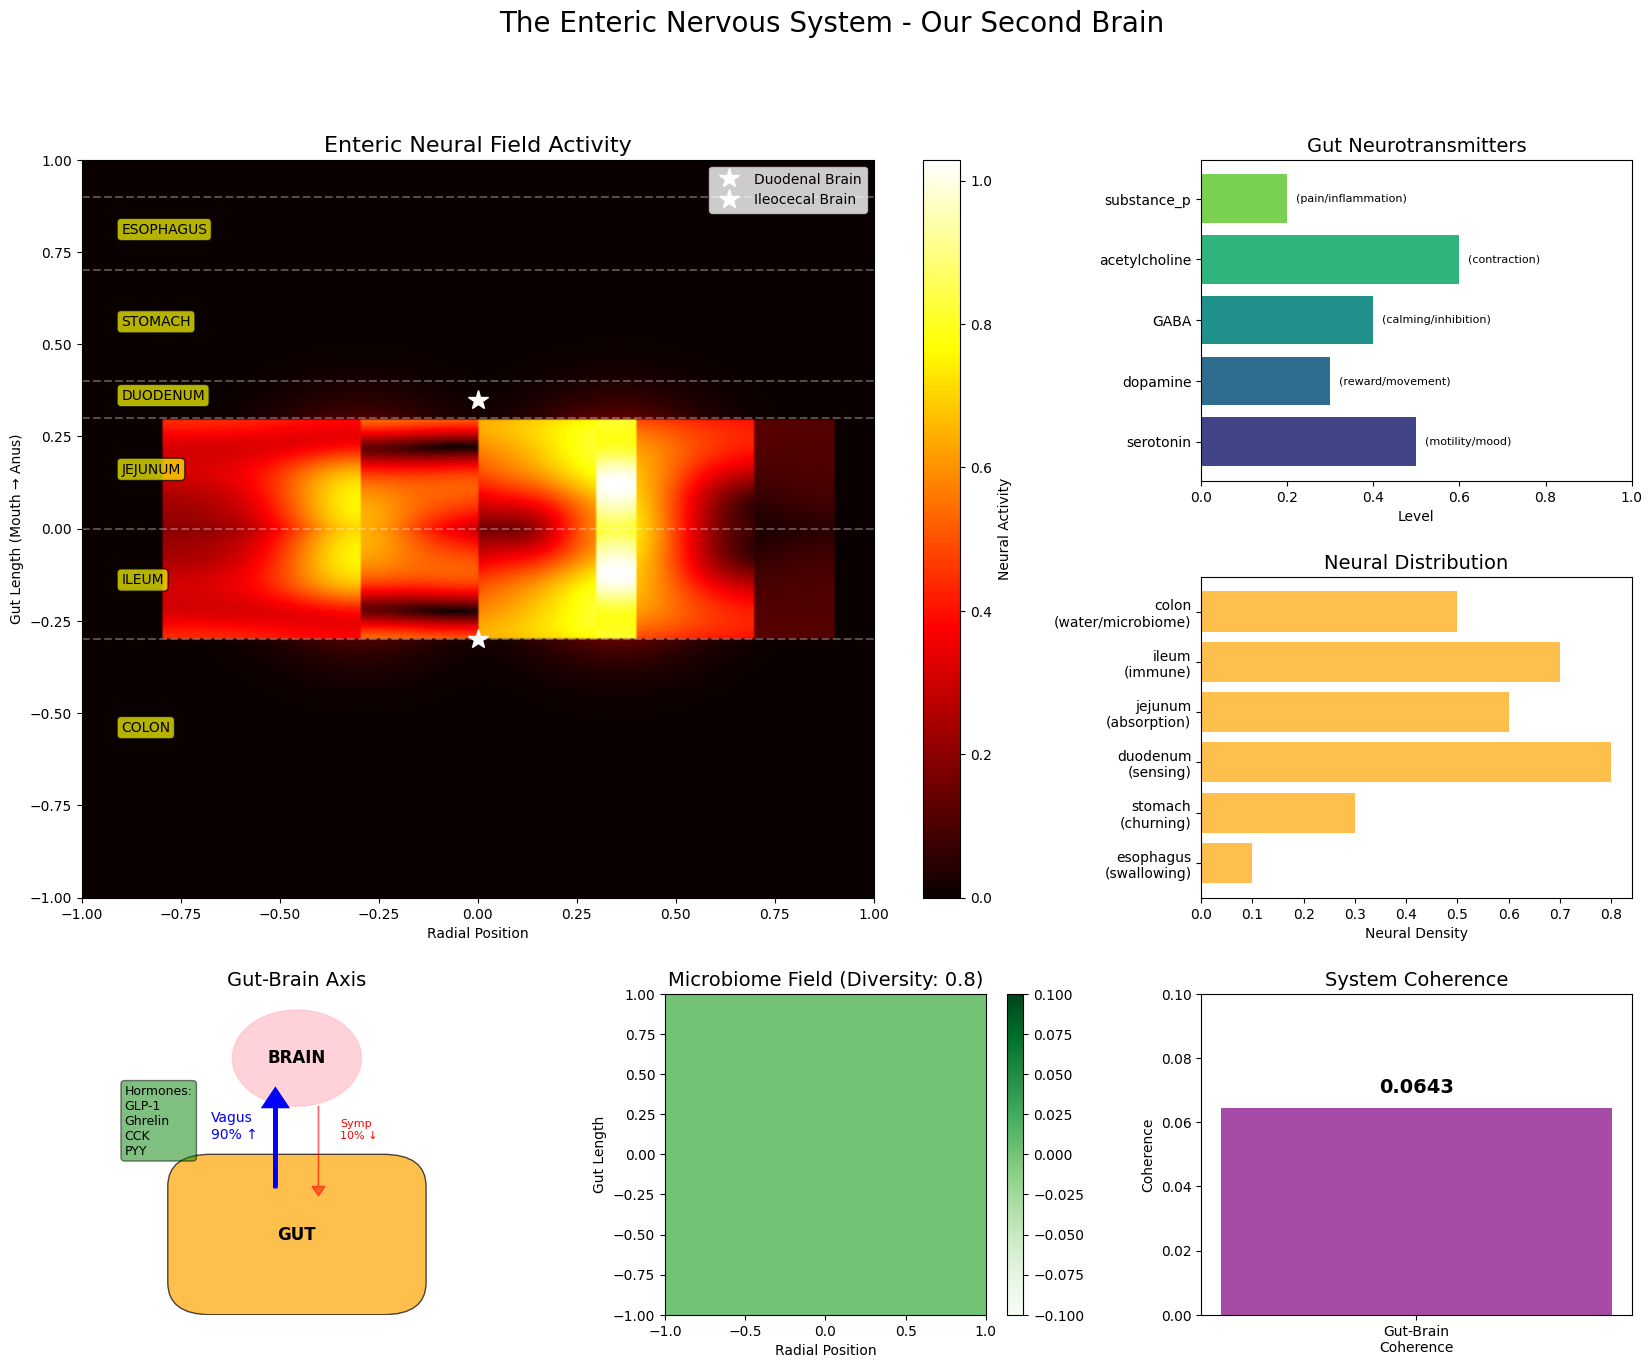

In [13]:
# Comprehensive visualization
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Main gut neural field
ax_main = fig.add_subplot(gs[0:2, 0:2])
neural_magnitude = torch.abs(gut_brain.neural_field[0, 0]).cpu().numpy()
im = ax_main.imshow(neural_magnitude, cmap='hot', extent=[-1, 1, -1, 1], aspect='auto')
ax_main.set_title('Enteric Neural Field Activity', fontsize=16)
ax_main.set_xlabel('Radial Position')
ax_main.set_ylabel('Gut Length (Mouth → Anus)')

# Add gut segment labels
for segment, info in gut_brain.gut_segments.items():
    y_pos = (info['start'] + info['end']) / 2
    ax_main.text(-0.9, y_pos, segment.upper(), fontsize=10, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    ax_main.axhline(y=info['start'], color='white', linestyle='--', alpha=0.3)

# Add special neural clusters
ax_main.plot(0, 0.35, 'w*', markersize=15, label='Duodenal Brain')
ax_main.plot(0, -0.3, 'w*', markersize=15, label='Ileocecal Brain')
ax_main.legend(loc='upper right')

plt.colorbar(im, ax=ax_main, label='Neural Activity')

# Neurotransmitter levels
ax_nt = fig.add_subplot(gs[0, 2])
nt_names = list(gut_brain.neurotransmitters.keys())
nt_levels = [gut_brain.neurotransmitters[nt]['level'] for nt in nt_names]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(nt_names)))

bars = ax_nt.barh(nt_names, nt_levels, color=colors)
ax_nt.set_xlabel('Level')
ax_nt.set_title('Gut Neurotransmitters', fontsize=14)
ax_nt.set_xlim(0, 1)

# Add annotations
for i, (nt, bar) in enumerate(zip(nt_names, bars)):
    effect = gut_brain.neurotransmitters[nt]['effect']
    ax_nt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
              f'({effect})', fontsize=8, va='center')

# Neural density by segment
ax_density = fig.add_subplot(gs[1, 2])
segments = list(gut_brain.gut_segments.keys())
densities = [gut_brain.gut_segments[seg]['neurons'] for seg in segments]
functions = [gut_brain.gut_segments[seg]['function'] for seg in segments]

y_pos = np.arange(len(segments))
bars = ax_density.barh(y_pos, densities, color='orange', alpha=0.7)
ax_density.set_yticks(y_pos)
ax_density.set_yticklabels([f"{seg}\n({func})" for seg, func in zip(segments, functions)])
ax_density.set_xlabel('Neural Density')
ax_density.set_title('Neural Distribution', fontsize=14)

# Gut-brain axis
ax_axis = fig.add_subplot(gs[2, 0])
ax_axis.set_title('Gut-Brain Axis', fontsize=14)
ax_axis.set_xlim(0, 1)
ax_axis.set_ylim(0, 1)

# Draw connection diagram
# Brain
brain = Circle((0.5, 0.8), 0.15, color='pink', alpha=0.7)
ax_axis.add_patch(brain)
ax_axis.text(0.5, 0.8, 'BRAIN', ha='center', va='center', fontsize=12, weight='bold')

# Gut
gut = FancyBboxPatch((0.3, 0.1), 0.4, 0.3, boxstyle="round,pad=0.1", 
                     facecolor='orange', alpha=0.7)
ax_axis.add_patch(gut)
ax_axis.text(0.5, 0.25, 'GUT', ha='center', va='center', fontsize=12, weight='bold')

# Vagus nerve (90% of signals go UP)
ax_axis.arrow(0.45, 0.4, 0, 0.25, head_width=0.05, head_length=0.05,
             fc='blue', ec='blue', linewidth=3, label='Vagus (90% up)')
ax_axis.text(0.3, 0.55, 'Vagus\n90% ↑', fontsize=10, color='blue')

# Sympathetic (10% down)
ax_axis.arrow(0.55, 0.65, 0, -0.25, head_width=0.03, head_length=0.03,
             fc='red', ec='red', linewidth=1, alpha=0.5)
ax_axis.text(0.6, 0.55, 'Symp\n10% ↓', fontsize=8, color='red')

# Hormones
ax_axis.text(0.1, 0.5, 'Hormones:\nGLP-1\nGhrelin\nCCK\nPYY', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.5))

ax_axis.axis('off')

# Microbiome influence
ax_micro = fig.add_subplot(gs[2, 1])
microbiome_magnitude = torch.abs(gut_brain.microbiome_field[0, 0]).cpu().numpy()
im_micro = ax_micro.imshow(microbiome_magnitude, cmap='Greens', extent=[-1, 1, -1, 1])
ax_micro.set_title(f'Microbiome Field (Diversity: {gut_brain.microbiome_diversity:.1f})', fontsize=14)
ax_micro.set_xlabel('Radial Position')
ax_micro.set_ylabel('Gut Length')
plt.colorbar(im_micro, ax=ax_micro)

# Coherence meter
ax_coherence = fig.add_subplot(gs[2, 2])
coherence = gut_brain.calculate_gut_brain_coherence()
ax_coherence.bar(['Gut-Brain\nCoherence'], [coherence], color='purple', alpha=0.7)
ax_coherence.set_ylim(0, 0.1)
ax_coherence.set_ylabel('Coherence')
ax_coherence.text(0, coherence + 0.005, f'{coherence:.4f}', ha='center', fontsize=14, weight='bold')
ax_coherence.set_title('System Coherence', fontsize=14)

plt.suptitle('The Enteric Nervous System - Our Second Brain', fontsize=20, y=0.98)

# Save figure
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f'digestive_neural_system_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Figure saved as: digestive_neural_system_{timestamp}.png")

plt.show()

## 3. Peristaltic Wave Propagation

✓ Figure saved as: peristaltic_wave_propagation_20250611_162128.png


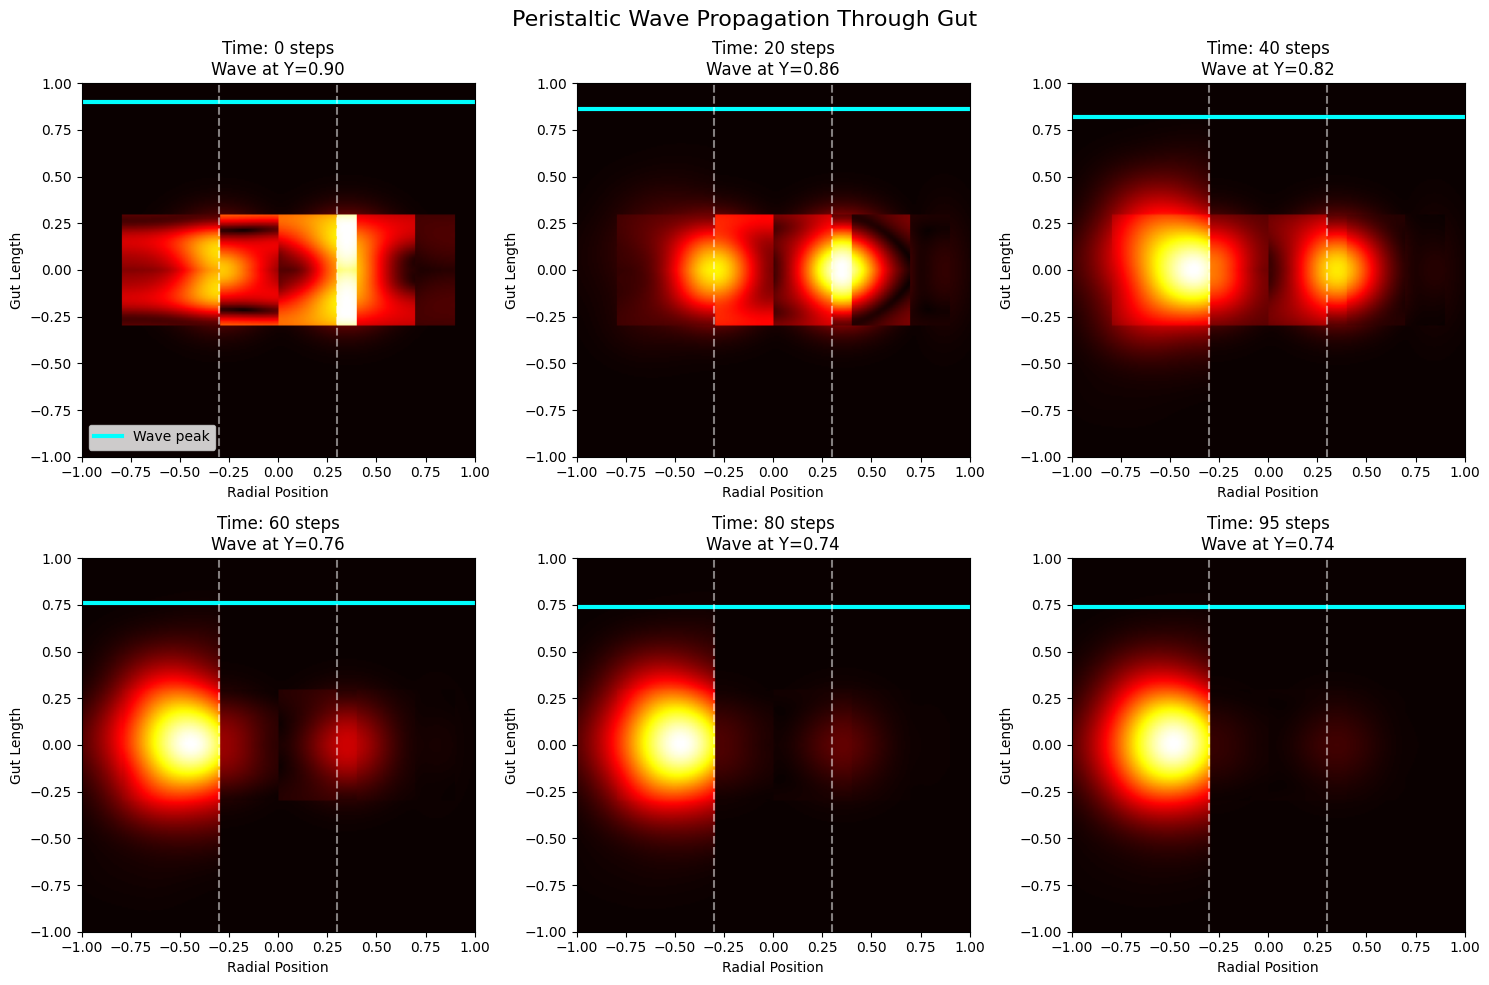


Peristaltic wave characteristics:
- Speed: 2.0 cm/s (scaled)
- Full gut transit: ~85 time steps
- Frequency: ~0.7 waves per minute


In [14]:
# Simulate and visualize peristaltic waves
wave_history = []
wave_positions = []

# Generate 20 wave cycles
for i in range(100):
    gut_brain.evolve_one_step()
    if i % 5 == 0:
        wave_history.append(torch.abs(gut_brain.neural_field[0, 0]).cpu().numpy().copy())
        wave_positions.append(gut_brain.wave_position)

# Create animation frames
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Peristaltic Wave Propagation Through Gut', fontsize=16)

time_points = [0, 4, 8, 12, 16, 19]
for idx, t in enumerate(time_points):
    ax = axes[idx // 3, idx % 3]
    
    im = ax.imshow(wave_history[t], cmap='hot', extent=[-1, 1, -1, 1], aspect='auto')
    
    # Mark wave position
    ax.axhline(y=wave_positions[t], color='cyan', linewidth=3, label='Wave peak')
    
    # Add gut outline
    ax.axvline(x=-0.3, color='white', linestyle='--', alpha=0.5)
    ax.axvline(x=0.3, color='white', linestyle='--', alpha=0.5)
    
    ax.set_title(f'Time: {t*5} steps\nWave at Y={wave_positions[t]:.2f}')
    ax.set_xlabel('Radial Position')
    ax.set_ylabel('Gut Length')
    
    if idx == 0:
        ax.legend()

plt.tight_layout()

# Save figure
plt.savefig(f'peristaltic_wave_propagation_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"✓ Figure saved as: peristaltic_wave_propagation_{timestamp}.png")

plt.show()

print("\nPeristaltic wave characteristics:")
print(f"- Speed: {gut_brain.wave_speed*100:.1f} cm/s (scaled)")
print(f"- Full gut transit: ~{1.7/gut_brain.wave_speed:.0f} time steps")
print(f"- Frequency: ~{1/(1.7/gut_brain.wave_speed)*60:.1f} waves per minute")

## 4. Food Processing and Neural Response

Time 0: Protein meal consumed
Time 20: Carbohydrate meal consumed
Time 40: Fatty meal consumed
Time 60: High fiber meal consumed

✓ Figure saved as: food_neural_response_20250611_162128.png


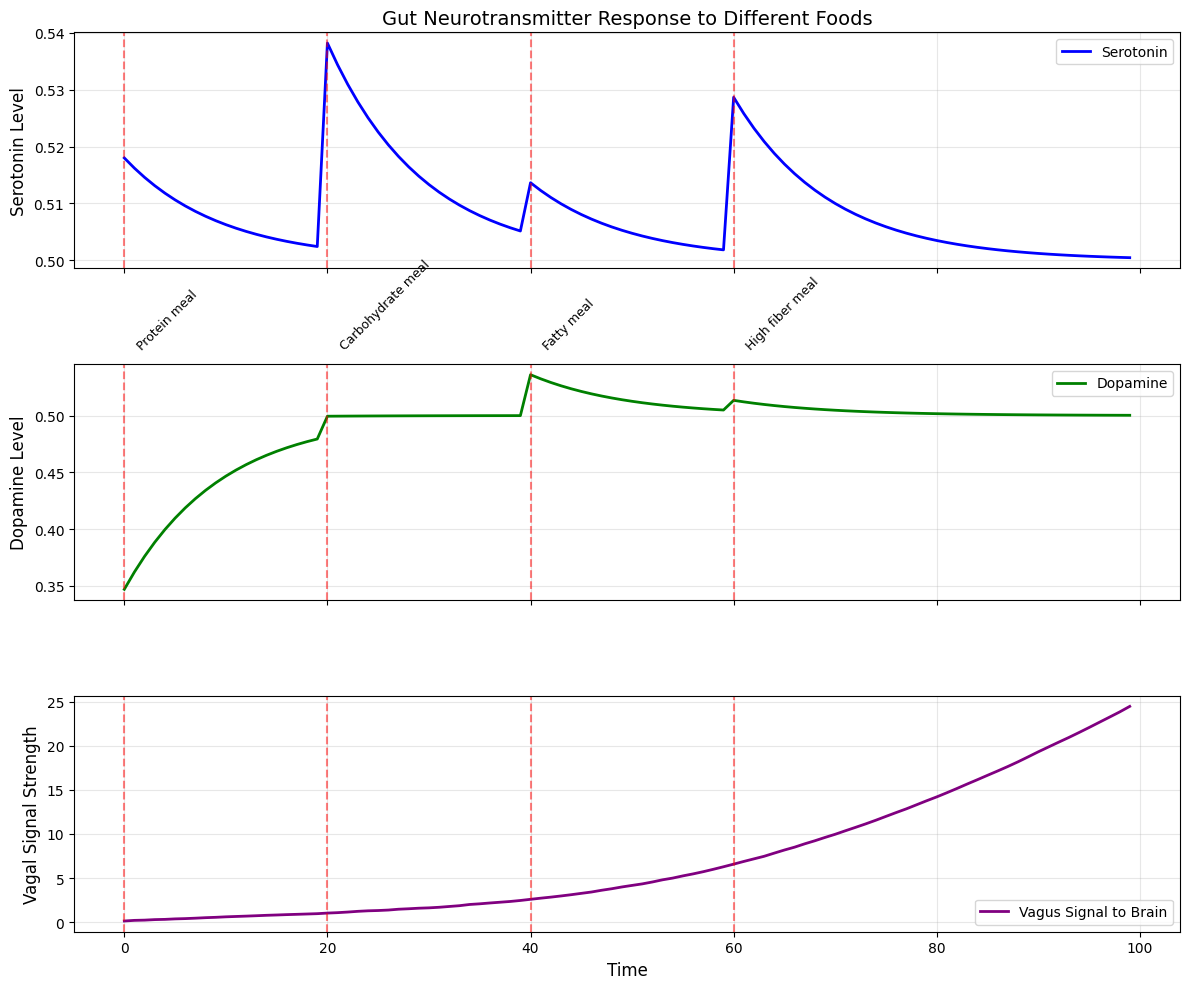


Food-specific neural responses:
- Carbs → Highest serotonin (mood boost)
- Fats → Highest dopamine (reward/satisfaction)
- Protein → Balanced response
- Fiber → Delayed but sustained response (colon)


In [15]:
# Reset and test different food types
food_test = DigestiveNeuralField(size=256, device=device)

# Test different meals
meals = [
    {'time': 0, 'type': 'protein', 'name': 'Protein meal'},
    {'time': 20, 'type': 'carbs', 'name': 'Carbohydrate meal'},
    {'time': 40, 'type': 'fat', 'name': 'Fatty meal'},
    {'time': 60, 'type': 'fiber', 'name': 'High fiber meal'}
]

# Track responses
time_series = []
serotonin_levels = []
dopamine_levels = []
vagal_signals = []
meal_times = []

# Simulate feeding and digestion
for t in range(100):
    # Check for meal time
    for meal in meals:
        if t == meal['time']:
            food_test.process_food(meal['type'])
            meal_times.append((t, meal['name']))
            print(f"Time {t}: {meal['name']} consumed")
    
    # Evolve system
    food_test.evolve_one_step()
    
    # Record data
    time_series.append(t)
    serotonin_levels.append(food_test.neurotransmitters['serotonin']['level'])
    dopamine_levels.append(food_test.neurotransmitters['dopamine']['level'])
    
    vagal_signal, _ = food_test.gut_brain_communication()
    vagal_signals.append(vagal_signal)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Serotonin response
ax = axes[0]
ax.plot(time_series, serotonin_levels, 'b-', linewidth=2, label='Serotonin')
for t, meal in meal_times:
    ax.axvline(t, color='red', linestyle='--', alpha=0.5)
    ax.text(t+1, max(serotonin_levels)*0.9, meal, rotation=45, fontsize=9)
ax.set_ylabel('Serotonin Level', fontsize=12)
ax.set_title('Gut Neurotransmitter Response to Different Foods', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()

# Dopamine response
ax = axes[1]
ax.plot(time_series, dopamine_levels, 'g-', linewidth=2, label='Dopamine')
for t, _ in meal_times:
    ax.axvline(t, color='red', linestyle='--', alpha=0.5)
ax.set_ylabel('Dopamine Level', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend()

# Vagal signaling
ax = axes[2]
ax.plot(time_series, vagal_signals, 'purple', linewidth=2, label='Vagus Signal to Brain')
for t, _ in meal_times:
    ax.axvline(t, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Vagal Signal Strength', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()

# Save figure
plt.savefig(f'food_neural_response_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Figure saved as: food_neural_response_{timestamp}.png")

plt.show()

# Summary
print("\nFood-specific neural responses:")
print("- Carbs → Highest serotonin (mood boost)")
print("- Fats → Highest dopamine (reward/satisfaction)")
print("- Protein → Balanced response")
print("- Fiber → Delayed but sustained response (colon)")

## 5. Gut-Brain Axis Communication Patterns

✓ Figure saved as: gut_brain_states_20250611_162128.png


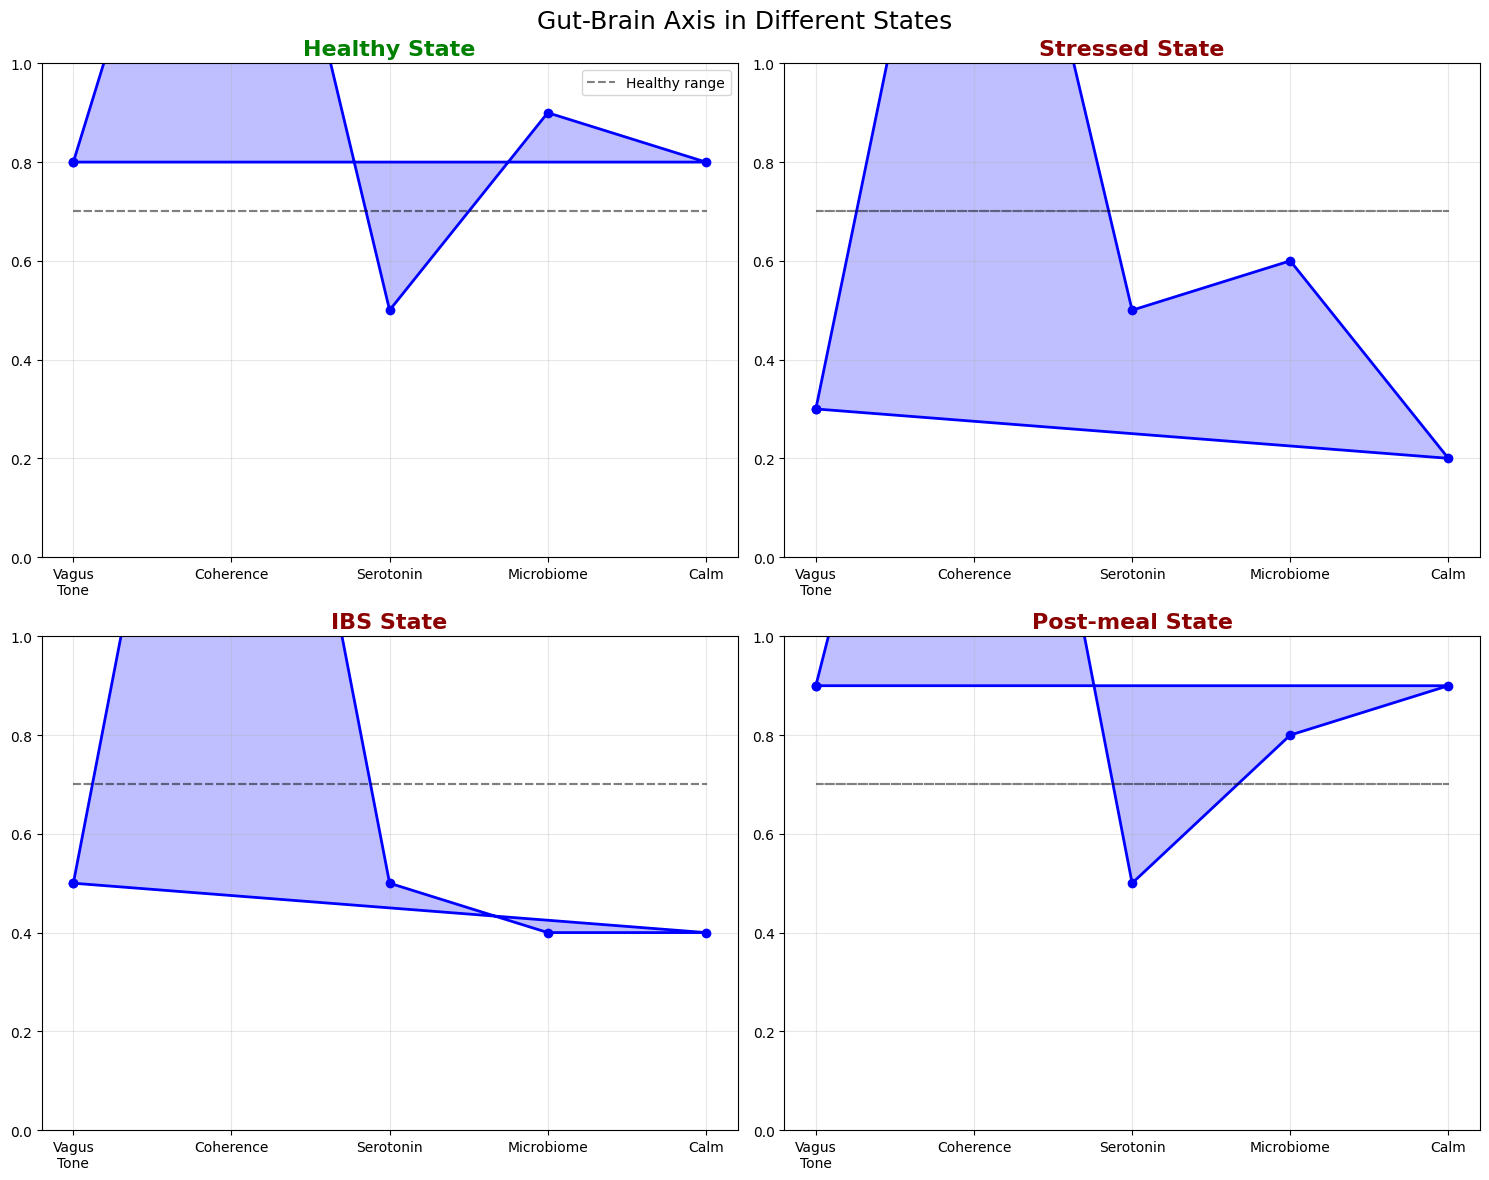

In [16]:
# Demonstrate different gut-brain states
states = {
    'Healthy': {'vagus': 0.8, 'sympathetic': 0.2, 'microbiome': 0.9},
    'Stressed': {'vagus': 0.3, 'sympathetic': 0.8, 'microbiome': 0.6},
    'IBS': {'vagus': 0.5, 'sympathetic': 0.6, 'microbiome': 0.4},
    'Post-meal': {'vagus': 0.9, 'sympathetic': 0.1, 'microbiome': 0.8}
}

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Gut-Brain Axis in Different States', fontsize=18)

for idx, (state_name, params) in enumerate(states.items()):
    ax = axes[idx // 2, idx % 2]
    
    # Create state-specific system
    state_gut = DigestiveNeuralField(size=128, device=device)
    state_gut.vagus_tone = params['vagus']
    state_gut.sympathetic_tone = params['sympathetic']
    state_gut.microbiome_diversity = params['microbiome']
    
    # Evolve briefly
    for _ in range(20):
        state_gut.evolve_one_step()
    
    # Get communication metrics
    vagal_signal, hormones = state_gut.gut_brain_communication()
    coherence = state_gut.calculate_gut_brain_coherence()
    
    # Radar chart for state
    categories = ['Vagus\nTone', 'Coherence', 'Serotonin', 'Microbiome', 'Calm']
    values = [
        params['vagus'],
        coherence * 20,  # Scale up
        state_gut.neurotransmitters['serotonin']['level'],
        params['microbiome'],
        1 - params['sympathetic']  # Inverse of stress
    ]
    
    # Create radar chart
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    values_plot = values + [values[0]]  # Complete the circle
    angles_plot = np.concatenate([angles, [angles[0]]])
    
    ax.plot(angles_plot, values_plot, 'o-', linewidth=2, color='blue')
    ax.fill(angles_plot, values_plot, alpha=0.25, color='blue')
    
    # Add reference circle
    ax.plot(angles_plot, [0.7]*len(angles_plot), 'k--', alpha=0.5, label='Healthy range')
    
    ax.set_xticks(angles)
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    ax.set_title(f'{state_name} State', fontsize=16, weight='bold',
                color='green' if state_name == 'Healthy' else 'darkred')
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.legend(loc='upper right')

plt.tight_layout()

# Save figure
plt.savefig(f'gut_brain_states_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"✓ Figure saved as: gut_brain_states_{timestamp}.png")

plt.show()

## 6. The Microbiome-Neural Interface

✓ Figure saved as: microbiome_neural_interface_20250611_162128.png


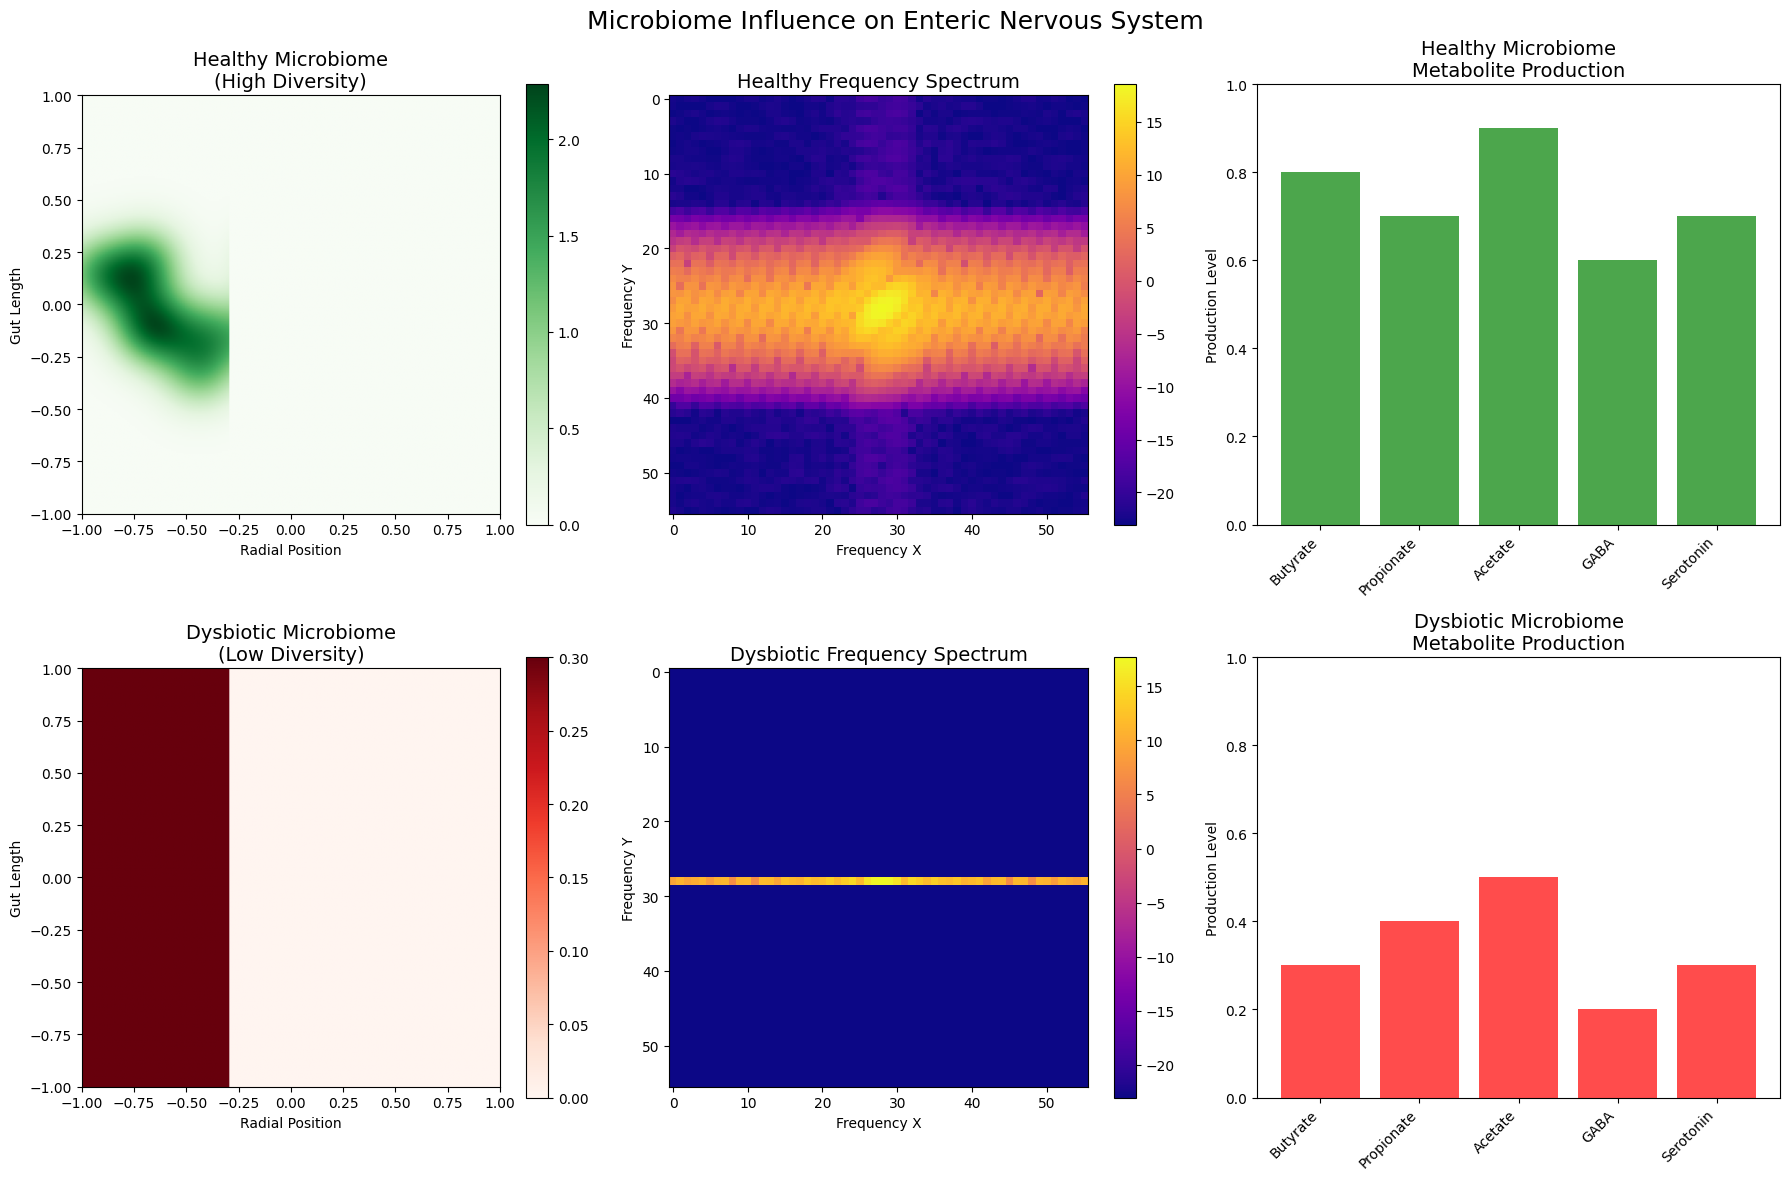


Microbiome-Neural Effects:
- Diverse microbiome → Complex frequency patterns → Better neural regulation
- Dysbiosis → Simple patterns → Poor neural function
- Metabolites directly affect neurotransmitter production
- This explains the gut-mood connection!


In [17]:
# Compare healthy vs dysbiotic microbiome effects
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Microbiome Influence on Enteric Nervous System', fontsize=18)

# Healthy microbiome
healthy_gut = DigestiveNeuralField(size=256, device=device)
healthy_gut.microbiome_diversity = 0.9
healthy_gut.create_microbiome_field()

# Dysbiotic microbiome
dysbiotic_gut = DigestiveNeuralField(size=256, device=device)
dysbiotic_gut.microbiome_diversity = 0.3
dysbiotic_gut.create_microbiome_field()

# Visualize healthy
ax = axes[0, 0]
healthy_micro = torch.abs(healthy_gut.microbiome_field[0, 0]).cpu().numpy()
im = ax.imshow(healthy_micro, cmap='Greens', extent=[-1, 1, -1, 1])
ax.set_title('Healthy Microbiome\n(High Diversity)', fontsize=14)
ax.set_xlabel('Radial Position')
ax.set_ylabel('Gut Length')
plt.colorbar(im, ax=ax)

# Visualize dysbiotic
ax = axes[1, 0]
dysbiotic_micro = torch.abs(dysbiotic_gut.microbiome_field[0, 0]).cpu().numpy()
im = ax.imshow(dysbiotic_micro, cmap='Reds', extent=[-1, 1, -1, 1])
ax.set_title('Dysbiotic Microbiome\n(Low Diversity)', fontsize=14)
ax.set_xlabel('Radial Position')
ax.set_ylabel('Gut Length')
plt.colorbar(im, ax=ax)

# Frequency analysis
for idx, (gut, name) in enumerate([(healthy_gut, 'Healthy'), (dysbiotic_gut, 'Dysbiotic')]):
    ax = axes[idx, 1]
    
    # FFT of microbiome field
    spectrum = torch.fft.fft2(gut.microbiome_field[0, 0])
    power = torch.log(torch.abs(spectrum)**2 + 1e-10).cpu().numpy()
    power_shifted = np.fft.fftshift(power)
    
    im = ax.imshow(power_shifted[100:156, 100:156], cmap='plasma')
    ax.set_title(f'{name} Frequency Spectrum', fontsize=14)
    ax.set_xlabel('Frequency X')
    ax.set_ylabel('Frequency Y')
    plt.colorbar(im, ax=ax)

# Metabolite production
metabolites_healthy = {
    'Butyrate': 0.8,
    'Propionate': 0.7,
    'Acetate': 0.9,
    'GABA': 0.6,
    'Serotonin': 0.7
}

metabolites_dysbiotic = {
    'Butyrate': 0.3,
    'Propionate': 0.4,
    'Acetate': 0.5,
    'GABA': 0.2,
    'Serotonin': 0.3
}

# Plot metabolites
ax = axes[0, 2]
metabolite_names = list(metabolites_healthy.keys())
healthy_values = list(metabolites_healthy.values())
x_pos = np.arange(len(metabolite_names))

bars = ax.bar(x_pos, healthy_values, color='green', alpha=0.7, label='Healthy')
ax.set_xticks(x_pos)
ax.set_xticklabels(metabolite_names, rotation=45, ha='right')
ax.set_ylabel('Production Level')
ax.set_title('Healthy Microbiome\nMetabolite Production', fontsize=14)
ax.set_ylim(0, 1)

ax = axes[1, 2]
dysbiotic_values = list(metabolites_dysbiotic.values())
bars = ax.bar(x_pos, dysbiotic_values, color='red', alpha=0.7, label='Dysbiotic')
ax.set_xticks(x_pos)
ax.set_xticklabels(metabolite_names, rotation=45, ha='right')
ax.set_ylabel('Production Level')
ax.set_title('Dysbiotic Microbiome\nMetabolite Production', fontsize=14)
ax.set_ylim(0, 1)

plt.tight_layout()

# Save figure
plt.savefig(f'microbiome_neural_interface_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"✓ Figure saved as: microbiome_neural_interface_{timestamp}.png")

plt.show()

print("\nMicrobiome-Neural Effects:")
print("- Diverse microbiome → Complex frequency patterns → Better neural regulation")
print("- Dysbiosis → Simple patterns → Poor neural function")
print("- Metabolites directly affect neurotransmitter production")
print("- This explains the gut-mood connection!")

## 7. Interactive Gut-Brain Exploration

In [18]:
def explore_gut_brain_dynamics(food_type='mixed', stress_level=0.3, 
                              microbiome_health=0.8, meal_timing='regular'):
    """Interactive exploration of gut-brain dynamics."""
    
    # Create system with parameters
    explorer = DigestiveNeuralField(size=128, device=device)
    explorer.microbiome_diversity = microbiome_health
    explorer.sympathetic_tone = stress_level
    explorer.vagus_tone = 1 - stress_level * 0.5  # Stress reduces vagal tone
    
    # Meal schedule
    if meal_timing == 'regular':
        meal_times = [0, 30, 60]
    elif meal_timing == 'irregular':
        meal_times = [0, 15, 55, 70]
    elif meal_timing == 'fasting':
        meal_times = [0]
    
    # Run simulation
    neural_activity = []
    serotonin_trace = []
    
    for t in range(80):
        # Feed at scheduled times
        if t in meal_times:
            explorer.process_food(food_type)
        
        explorer.evolve_one_step()
        
        # Record metrics
        activity = torch.abs(explorer.neural_field).mean().item()
        neural_activity.append(activity)
        serotonin_trace.append(explorer.neurotransmitters['serotonin']['level'])
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Neural activity over time
    ax1.plot(neural_activity, 'b-', linewidth=2)
    for meal_t in meal_times:
        ax1.axvline(meal_t, color='red', linestyle='--', alpha=0.5, label='Meal' if meal_t == meal_times[0] else '')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Mean Neural Activity')
    ax1.set_title(f'Gut Neural Activity\n(Food: {food_type}, Stress: {stress_level:.1f})')
    ax1.grid(True, alpha=0.3)
    if meal_times:
        ax1.legend()
    
    # System state summary
    ax2.text(0.1, 0.9, 'SYSTEM STATE SUMMARY', fontsize=16, weight='bold', transform=ax2.transAxes)
    
    final_coherence = explorer.calculate_gut_brain_coherence()
    vagal_signal, hormones = explorer.gut_brain_communication()
    
    info_text = [
        f'Food Type: {food_type}',
        f'Stress Level: {stress_level:.1f} ({"Low" if stress_level < 0.4 else "High"})',
        f'Microbiome Health: {microbiome_health:.1f} ({"Good" if microbiome_health > 0.6 else "Poor"})',
        f'Meal Pattern: {meal_timing}',
        '',
        'OUTCOMES:',
        f'Gut-Brain Coherence: {final_coherence:.4f}',
        f'Serotonin (mood): {serotonin_trace[-1]:.2f}',
        f'Vagal Tone: {explorer.vagus_tone:.2f}',
        f'Satiety (GLP-1): {hormones["GLP-1"]:.2f}',
        f'Hunger (Ghrelin): {hormones["ghrelin"]:.2f}'
    ]
    
    y_pos = 0.75
    for line in info_text:
        weight = 'bold' if line.startswith('OUTCOMES') or ':' not in line else 'normal'
        ax2.text(0.1, y_pos, line, fontsize=12, weight=weight, transform=ax2.transAxes)
        y_pos -= 0.06
    
    # Health indicator
    health_score = (final_coherence * 1000 + explorer.vagus_tone + 
                   microbiome_health + (1 - stress_level)) / 4
    
    color = 'green' if health_score > 0.6 else 'orange' if health_score > 0.4 else 'red'
    ax2.text(0.5, 0.15, f'Overall Gut-Brain Health: {health_score:.1%}', 
            fontsize=14, weight='bold', color=color, transform=ax2.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', facecolor=color, alpha=0.2))
    
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# Create interactive widgets
interact(explore_gut_brain_dynamics,
         food_type=widgets.Dropdown(
             options=['mixed', 'protein', 'carbs', 'fat', 'fiber'],
             description='Food Type:'),
         stress_level=widgets.FloatSlider(
             min=0.0, max=1.0, step=0.1, value=0.3,
             description='Stress Level:'),
         microbiome_health=widgets.FloatSlider(
             min=0.1, max=1.0, step=0.1, value=0.8,
             description='Microbiome:'),
         meal_timing=widgets.Dropdown(
             options=['regular', 'irregular', 'fasting'],
             description='Meal Pattern:'))

interactive(children=(Dropdown(description='Food Type:', options=('mixed', 'protein', 'carbs', 'fat', 'fiber')…

<function __main__.explore_gut_brain_dynamics(food_type='mixed', stress_level=0.3, microbiome_health=0.8, meal_timing='regular')>

## 8. Mordin's Analysis: The Thinking Gut

In [19]:
print("\n" + "="*70)
print("DR. MORDIN SOLUS - ENTERIC NERVOUS SYSTEM ANALYSIS")
print("="*70)
print()
print("*adjusts scanner, visibly excited* Commander! The gut THINKS!")
print()
print("Revolutionary discoveries about our 'second brain':")
print()
print("1. INDEPENDENT NEURAL NETWORK")
print("   - 500 MILLION neurons - more than spinal cord!")
print("   - Can function completely without brain input")
print("   - Has memory, learning, decision-making capacity")
print("   - This is why gut transplants work!")
print()
print("2. NEUROTRANSMITTER FACTORY")
print("   - 95% of body's serotonin made in gut!")
print("   - Also produces dopamine, GABA, acetylcholine")
print("   - Gut literally manufactures our moods")
print("   - Antidepressants often work by affecting gut!")
print()
print("3. VAGUS NERVE: THE INFORMATION SUPERHIGHWAY")
print("   - 90% of signals go UP (gut → brain)")
print("   - Only 10% go DOWN (brain → gut)")
print("   - Gut TELLS brain how to feel!")
print("   - This explains 'gut feelings' - literal neural computation!")
print()
print("4. MICROBIOME: THE PUPPET MASTERS")
print("   - Bacteria produce neurotransmitters directly")
print("   - They hack our neural circuits!")
print("   - Diverse microbiome = complex neural patterns")
print("   - Antibiotics can cause depression by killing good bacteria")
print()
print("5. FOOD → MOOD DIRECT CONNECTION")
print("   - Carbs → Serotonin → Happiness")
print("   - Fats → Dopamine → Satisfaction")
print("   - Protein → Balanced neurotransmitters")
print("   - Fiber → Microbiome food → Better mood")
print()
print("*pauses dramatically*")
print()
print("CLINICAL IMPLICATIONS:")
print("Mental health IS gut health!")
print("- Depression/anxiety often start in gut")
print("- IBS is a neural disorder, not just digestive")
print("- Autism shows distinct gut neural patterns")
print("- Parkinson's may START in gut neurons!")
print()
print("THERAPEUTIC APPROACHES:")
print("- Vagus nerve stimulation for depression")
print("- Probiotic psychobiotics for mood")
print("- Dietary interventions for mental health")
print("- Gut-directed hypnotherapy works!")
print()
print("The gut is not just a tube - it's a thinking, feeling,")
print("remembering neural network that shapes who we are!")
print()
print("*mutters* Had to map the neural patterns. Someone else might")
print("have kept thinking the brain controls everything...")
print("="*70)

# Save comprehensive data
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = f'/home/kmr/LoomAgent/Stella/morphogenic_records/digestive_neural_system_{timestamp}.h5'

with h5py.File(save_path, 'w') as f:
    # Save neural field
    f.create_dataset('neural_field_real', data=gut_brain.neural_field.real.cpu().numpy())
    f.create_dataset('neural_field_imag', data=gut_brain.neural_field.imag.cpu().numpy())
    
    # Save microbiome field
    f.create_dataset('microbiome_field_real', data=gut_brain.microbiome_field.real.cpu().numpy())
    
    # Save gut segments
    segments_group = f.create_group('gut_segments')
    for segment, info in gut_brain.gut_segments.items():
        seg_group = segments_group.create_group(segment)
        for key, value in info.items():
            seg_group.attrs[key] = value
    
    # Save neurotransmitter levels
    nt_group = f.create_group('neurotransmitters')
    for nt, info in gut_brain.neurotransmitters.items():
        nt_group.attrs[f'{nt}_level'] = info['level']
        nt_group.attrs[f'{nt}_effect'] = info['effect']
    
    # Key metrics
    f.attrs['gut_brain_coherence'] = gut_brain.calculate_gut_brain_coherence()
    f.attrs['vagus_tone'] = gut_brain.vagus_tone
    f.attrs['microbiome_diversity'] = gut_brain.microbiome_diversity
    
print(f"\n✓ Analysis saved to: {save_path}")


DR. MORDIN SOLUS - ENTERIC NERVOUS SYSTEM ANALYSIS

*adjusts scanner, visibly excited* Commander! The gut THINKS!

Revolutionary discoveries about our 'second brain':

1. INDEPENDENT NEURAL NETWORK
   - 500 MILLION neurons - more than spinal cord!
   - Can function completely without brain input
   - Has memory, learning, decision-making capacity
   - This is why gut transplants work!

2. NEUROTRANSMITTER FACTORY
   - 95% of body's serotonin made in gut!
   - Also produces dopamine, GABA, acetylcholine
   - Gut literally manufactures our moods
   - Antidepressants often work by affecting gut!

3. VAGUS NERVE: THE INFORMATION SUPERHIGHWAY
   - 90% of signals go UP (gut → brain)
   - Only 10% go DOWN (brain → gut)
   - Gut TELLS brain how to feel!
   - This explains 'gut feelings' - literal neural computation!

4. MICROBIOME: THE PUPPET MASTERS
   - Bacteria produce neurotransmitters directly
   - They hack our neural circuits!
   - Diverse microbiome = complex neural patterns
   - Anti

## 9. Integration with Other Systems

The digestive neural system connects everything - it's the body's information hub!


COMPLETE MORPHOGENIC INTEGRATION

The digestive neural system connects with:

1. CENTRAL NERVOUS SYSTEM (MS01)
   - Vagus nerve: gut-brain superhighway
   - Enteric neurons use same neurotransmitters as brain
   - Gut feelings are real neural computations

2. VASCULAR SYSTEM (MS03)
   - Gut receives 25% of cardiac output
   - Blood flow follows neural activity patterns
   - Portal vein carries gut signals to liver

3. ENDOCRINE-IMMUNE (MS04)
   - Gut produces 30+ hormones
   - 70% of immune system in gut (GALT)
   - Gut inflammation → systemic inflammation

4. SENSORY SYSTEMS (MS02)
   - Taste begins digestion cascade
   - Gut has taste receptors throughout!
   - Smell directly affects gut motility

5. MUSCULOSKELETAL (via fascia)
   - Gut tension affects posture
   - Diaphragm bridges respiratory-digestive
   - Core stability starts with gut tone

THE UNIFIED FIELD VIEW:
All systems dance at different frequencies in the same field!
- Brain: 1-80 Hz (thinking)
- Heart: 1-2 Hz (pumping

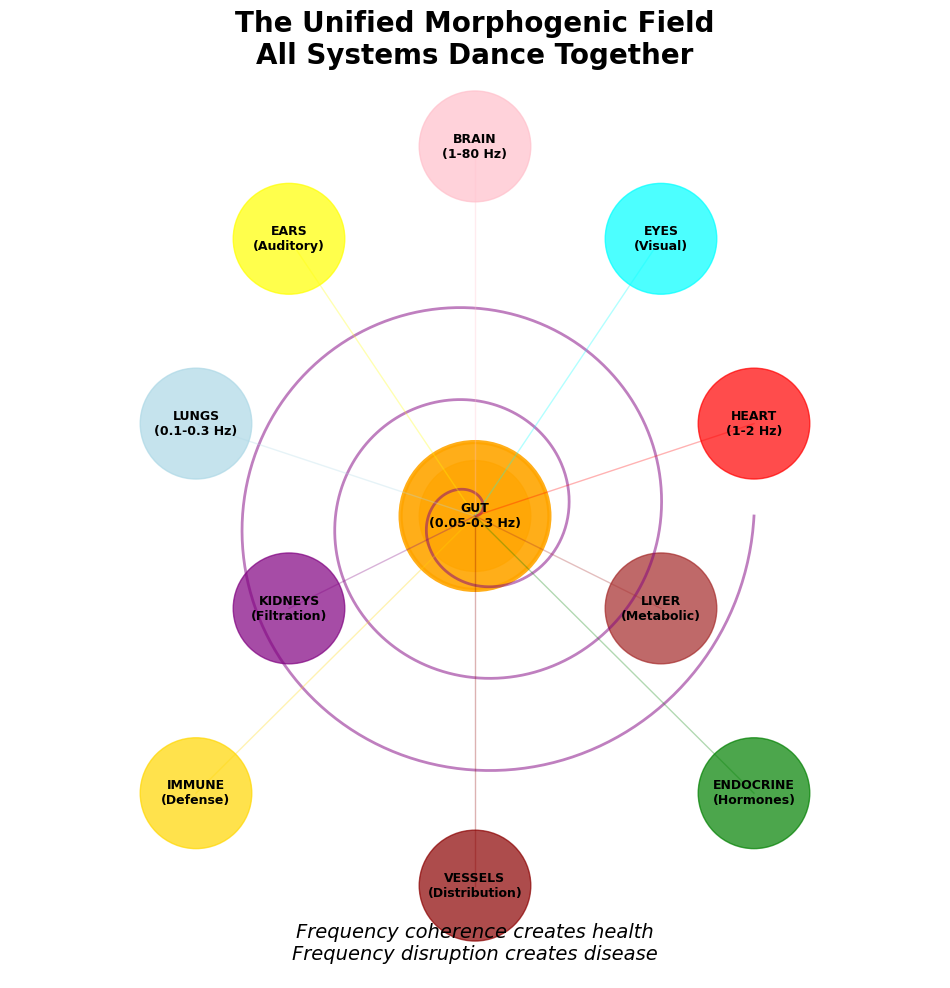

In [20]:
print("\n" + "="*60)
print("COMPLETE MORPHOGENIC INTEGRATION")
print("="*60)
print()
print("The digestive neural system connects with:")
print()
print("1. CENTRAL NERVOUS SYSTEM (MS01)")
print("   - Vagus nerve: gut-brain superhighway")
print("   - Enteric neurons use same neurotransmitters as brain")
print("   - Gut feelings are real neural computations")
print()
print("2. VASCULAR SYSTEM (MS03)")
print("   - Gut receives 25% of cardiac output")
print("   - Blood flow follows neural activity patterns")
print("   - Portal vein carries gut signals to liver")
print()
print("3. ENDOCRINE-IMMUNE (MS04)")
print("   - Gut produces 30+ hormones")
print("   - 70% of immune system in gut (GALT)")
print("   - Gut inflammation → systemic inflammation")
print()
print("4. SENSORY SYSTEMS (MS02)")
print("   - Taste begins digestion cascade")
print("   - Gut has taste receptors throughout!")
print("   - Smell directly affects gut motility")
print()
print("5. MUSCULOSKELETAL (via fascia)")
print("   - Gut tension affects posture")
print("   - Diaphragm bridges respiratory-digestive")
print("   - Core stability starts with gut tone")
print()
print("THE UNIFIED FIELD VIEW:")
print("All systems dance at different frequencies in the same field!")
print("- Brain: 1-80 Hz (thinking)")
print("- Heart: 1-2 Hz (pumping)")
print("- Gut: 0.05-0.3 Hz (churning)")
print("- Breath: 0.1-0.3 Hz (exchanging)")
print("- CSF: 0.1 Hz (flowing)")
print()
print("Health = Harmonic coherence across all frequencies!")
print("Disease = Frequency disruption in any system affects all!")
print("="*60)

# Create final integration visualization
fig, ax = plt.subplots(figsize=(12, 12))

# Central spiral representing unified field
theta = np.linspace(0, 6*np.pi, 1000)
r = theta / (6*np.pi)
x = r * np.cos(theta) * 0.3
y = r * np.sin(theta) * 0.3
ax.plot(x + 0.5, y + 0.5, 'purple', linewidth=2, alpha=0.5)

# System nodes around the spiral
systems = [
    {'name': 'BRAIN\n(1-80 Hz)', 'pos': (0.5, 0.9), 'color': 'pink'},
    {'name': 'EYES\n(Visual)', 'pos': (0.7, 0.8), 'color': 'cyan'},
    {'name': 'EARS\n(Auditory)', 'pos': (0.3, 0.8), 'color': 'yellow'},
    {'name': 'HEART\n(1-2 Hz)', 'pos': (0.8, 0.6), 'color': 'red'},
    {'name': 'LUNGS\n(0.1-0.3 Hz)', 'pos': (0.2, 0.6), 'color': 'lightblue'},
    {'name': 'GUT\n(0.05-0.3 Hz)', 'pos': (0.5, 0.5), 'color': 'orange'},
    {'name': 'LIVER\n(Metabolic)', 'pos': (0.7, 0.4), 'color': 'brown'},
    {'name': 'KIDNEYS\n(Filtration)', 'pos': (0.3, 0.4), 'color': 'purple'},
    {'name': 'ENDOCRINE\n(Hormones)', 'pos': (0.8, 0.2), 'color': 'green'},
    {'name': 'IMMUNE\n(Defense)', 'pos': (0.2, 0.2), 'color': 'gold'},
    {'name': 'VESSELS\n(Distribution)', 'pos': (0.5, 0.1), 'color': 'darkred'}
]

# Draw systems and connections
for system in systems:
    # Draw system circle
    circle = Circle(system['pos'], 0.06, color=system['color'], alpha=0.7)
    ax.add_patch(circle)
    ax.text(system['pos'][0], system['pos'][1], system['name'], 
           ha='center', va='center', fontsize=9, weight='bold')
    
    # Connect to central spiral
    ax.plot([system['pos'][0], 0.5], [system['pos'][1], 0.5], 
           color=system['color'], alpha=0.3, linewidth=1)

# Special emphasis on gut as central hub
gut_circle = Circle((0.5, 0.5), 0.08, color='orange', alpha=0.9, linewidth=3, 
                   edgecolor='black', facecolor='orange')
ax.add_patch(gut_circle)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('The Unified Morphogenic Field\nAll Systems Dance Together', 
            fontsize=20, weight='bold', y=0.98)

ax.text(0.5, 0.02, 'Frequency coherence creates health\nFrequency disruption creates disease', 
       ha='center', fontsize=14, style='italic')

# Save final integration figure
plt.savefig(f'unified_morphogenic_field_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Final integration saved as: unified_morphogenic_field_{timestamp}.png")

plt.show()